In [1]:
"""
Notebook Matrix Profile – SWT Python 3.11 package

Goal:
From pre processing signal with original value, normalize value, timestamp. 
We identify discord and motifs with matrix profile methode (stumpy.aamp)
"""

# ---- Package imports ----

import time
start_import =  time.perf_counter()

# Numerical computation
import numpy as np
from scipy.stats import pearsonr

# Data manipulation
import pandas as pd
from pandas.tseries.frequencies import to_offset

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


#Matrix profile
import stumpy

#DTW, process signal
from tslearn.metrics import soft_dtw

In [2]:
# --- import of CSV file ---
start_import =  time.perf_counter()

# get original dataframe
df = pd.read_csv('../../dataset/ambient_temperature_system_failure_preprocessed.csv')

In [3]:
start_matrix_profile = time.perf_counter()


def compute_centroid(motif_list):
    """Compute average motif (centroid) from a list of motifs"""
    return np.mean(motif_list, axis=0)

def is_similar_to_existing_sets_soft_dtw(Q, previous_motif_sets, max_soft_dtw_dist, gamma, delta):
    """
    Compare Q to each motif in previous sets using Soft-DTW, allowing small shifts (±delta).
    """
    Q = np.asarray(Q).reshape(-1, 1)
    for motif_list in previous_motif_sets:
        for motif in motif_list:
            motif = np.asarray(motif).reshape(-1, 1)
            best_dist = float('inf')

            # Slide window over a small range to tolerate minor shifts
            for shift in range(-delta, delta + 1):
                if shift < 0:
                    Q_shifted = Q[-shift:]  # Trim start
                    motif_trimmed = motif[:len(Q_shifted)]
                elif shift > 0:
                    Q_shifted = Q[:-shift]  # Trim end
                    motif_trimmed = motif[shift:shift+len(Q_shifted)]
                else:
                    Q_shifted = Q
                    motif_trimmed = motif

                if len(Q_shifted) < 5 or len(Q_shifted) != len(motif_trimmed):
                    continue

                dist = soft_dtw(Q_shifted, motif_trimmed, gamma=gamma)
                if dist < best_dist:
                    best_dist = dist

            if best_dist < max_soft_dtw_dist:
                return True  # Considered duplicate
    return False

def infer_optimal_window_size(df, signal_col='value', timestamp_col='timestamp',
                               min_m=30, max_m_ratio=0.25, motif_duration_sec=600):
    """
    Automatically infers an optimal sliding window size (m) for Matrix Profile analysis
    based on time granularity and expected motif duration.
    """
    df = df.copy()
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
    df = df.dropna(subset=[timestamp_col, signal_col])

    n = len(df)
    max_m = int(n * max_m_ratio)

    median_delta = df[timestamp_col].diff().median()
    sampling_interval = median_delta.total_seconds() if pd.notna(median_delta) and median_delta.total_seconds() != 0 else 1

    m = int(motif_duration_sec / sampling_interval)
    m = max(min_m, min(m, max_m))
    if m % 2 == 0:
        m += 1

    print(f"[Matrix Profile] Auto-inferred window size m = {m} "
          f"(sampling ≈ {sampling_interval:.2f}s, len={n})")
    return m

# ---------------------------------------
# 1. Determine optimal subsequence length
m = infer_optimal_window_size(df, signal_col='value', timestamp_col='timestamp')

# 2. Mask interpolated regions (if any)
interpolated_mask = df['original_value'].isna()
clean_signal = df['value'].copy()

# Interpolate only to compute matrix profile without NaNs
signal_interp = clean_signal.interpolate(method='linear', limit_direction='both')
signal_interp = signal_interp.astype(np.float64)

# 3. Compute matrix profile using AAMP (on interpolated version)
matrix_profile = stumpy.aamp(signal_interp.values, m)

# Filter valid subsequences: only those with no interpolated data
def is_valid_window(index, mask, window_size):
    return index + window_size <= len(mask) and not mask[index:index + window_size].any()

valid_indices = np.array([
    i for i in range(len(matrix_profile))
    if is_valid_window(i, interpolated_mask.values, m)
])

# 4. Identify the main motif (minimum distance pair)
motif_start = int(valid_indices[np.argmin(matrix_profile[valid_indices, 0])])

# Greedy multi-motif discovery (with AAMP matrix profile)
mp_distances = matrix_profile[:, 0].astype(np.float64)
cutoff = np.percentile(mp_distances[np.isfinite(mp_distances)], 10)
exclusion_zone = int(m / 5)
max_motif_sets = 5  # number of different motif families to find

valid_indices = np.array([
    i for i in range(len(matrix_profile))
    if i + m <= len(df) and not interpolated_mask.iloc[i:i+m].any()
])

remaining_indices = valid_indices.copy()
motif_sets = []
used_mask = np.zeros(len(matrix_profile), dtype=bool)

previous_motif_sets = []

while len(remaining_indices) > 0 and len(motif_sets) < max_motif_sets:
    current_best_idx = int(remaining_indices[np.argmin(matrix_profile[remaining_indices, 0])])
    Q = signal_interp[current_best_idx : current_best_idx + m]

    if is_similar_to_existing_sets_soft_dtw(Q, previous_motif_sets, max_soft_dtw_dist=1.5, gamma=0.5, delta =int(m * 0.20)):
        # Skip similar motif
        start = max(0, current_best_idx - exclusion_zone)
        end = min(len(used_mask), current_best_idx + exclusion_zone)
        used_mask[start:end] = True
        remaining_indices = [i for i in remaining_indices if not used_mask[i]]
        continue

    # Find all neighbors of Q
    matches = stumpy.aamp_match(Q, signal_interp, max_distance=cutoff)
    motif_neighbors_idx = [int(match[1]) for match in matches]
    motif_list = [signal_interp[idx:idx+m] for idx in [current_best_idx] + motif_neighbors_idx]

    # Save current motif family
    motif_sets.append([current_best_idx] + motif_neighbors_idx)
    previous_motif_sets.append(motif_list)

    for idx in [current_best_idx] + motif_neighbors_idx:
        start = max(0, idx - exclusion_zone)
        end = min(len(used_mask), idx + exclusion_zone)
        used_mask[start:end] = True

    remaining_indices = [i for i in remaining_indices if not used_mask[i]]


# 5. Detect the discord (most distant subsequence)
# Exclude invalid values (NaN, inf) and filtered regions
mp_distances = np.array(matrix_profile[:, 0], dtype=np.float64)
valid_discord_candidates = valid_indices[np.isfinite(mp_distances[valid_indices])]

# Sort by distance descending
sorted_discords = valid_discord_candidates[np.argsort(mp_distances[valid_discord_candidates])[::-1]]

# Apply exclusion zone around motif and neighbors
exclusion_zone = int(m / 2)
valid_mask = np.ones(len(matrix_profile), dtype=bool)

for idx in [motif_start] + motif_neighbors_idx:
    start = max(0, idx - exclusion_zone)
    end = min(len(valid_mask), idx + exclusion_zone)
    valid_mask[start:end] = False

# Final discord index
final_discords = [idx for idx in sorted_discords if valid_mask[idx]]
discord_start = final_discords[0]

# 6. Align matrix profile with full signal length
df['matrix_profile'] = [None] * (m - 1) + matrix_profile[:, 0].tolist()

end_matrix_profile = time.perf_counter()
print(f"Total processing time: {end_matrix_profile - start_matrix_profile:.4f} seconds")


[Matrix Profile] Auto-inferred window size m = 31 (sampling ≈ 3600.00s, len=7888)
Total processing time: 12.9325 seconds


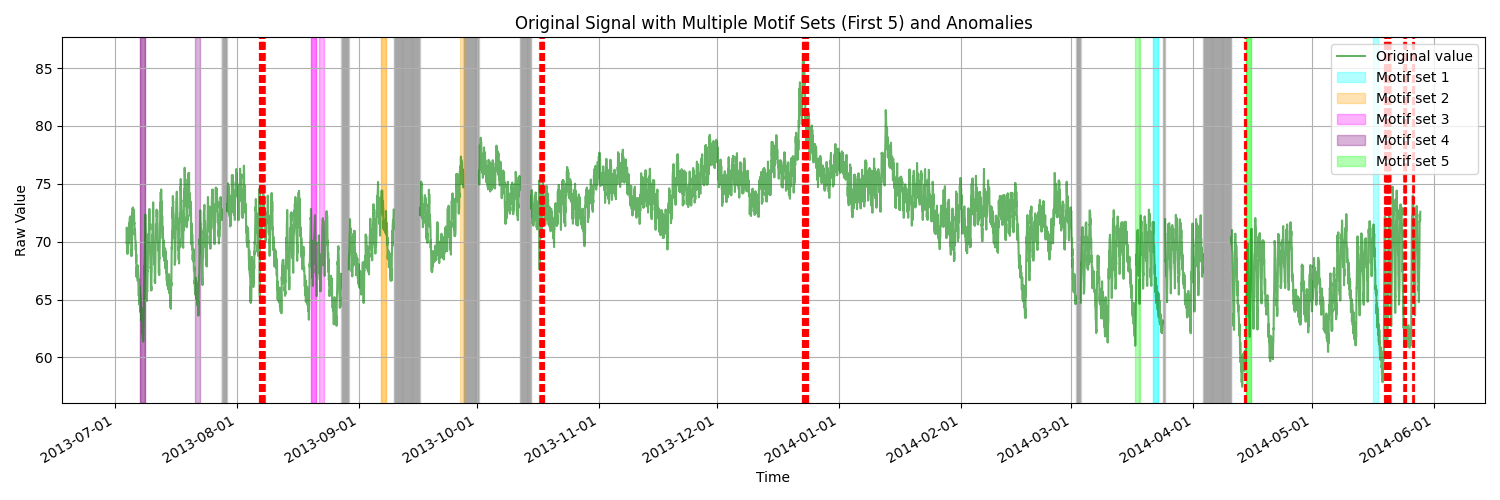

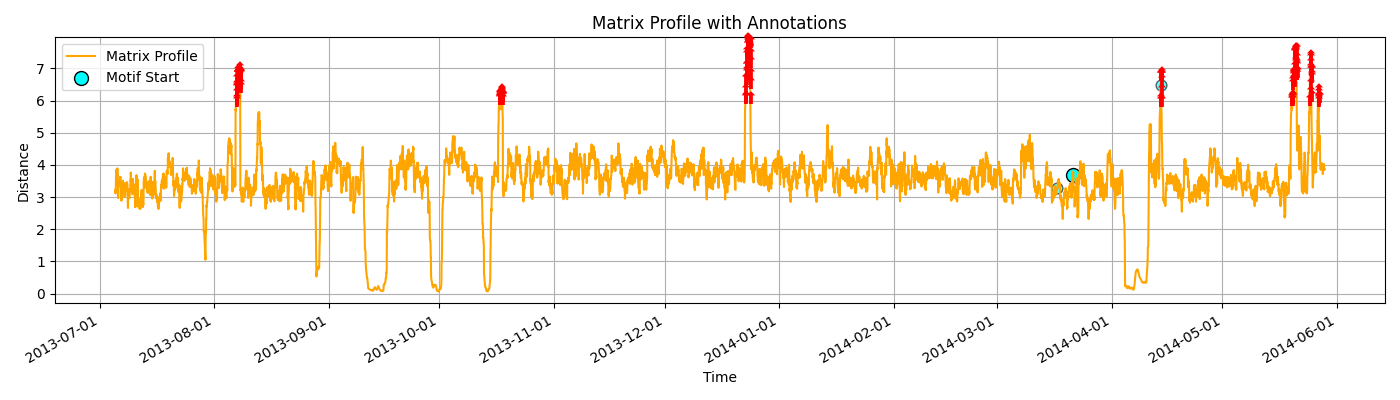

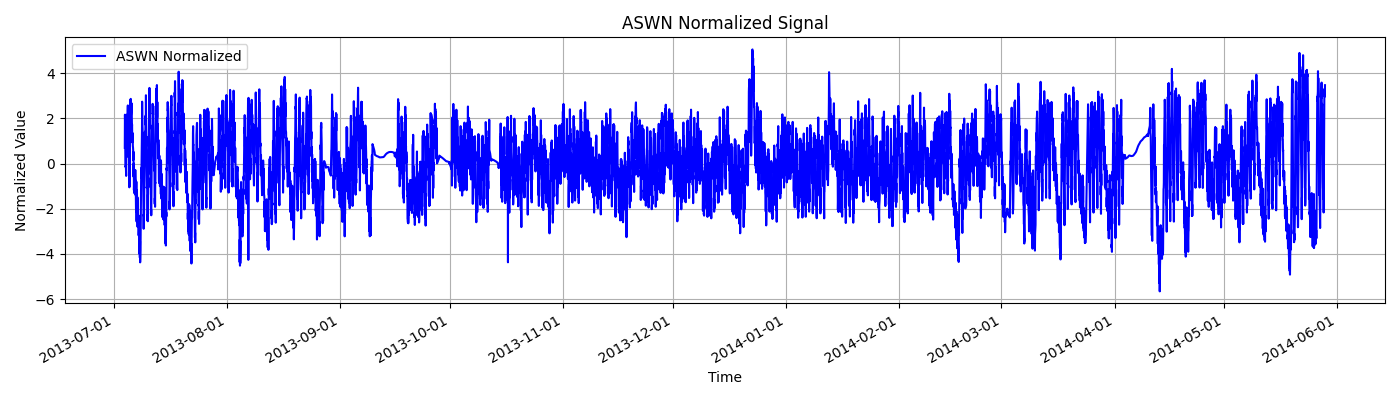

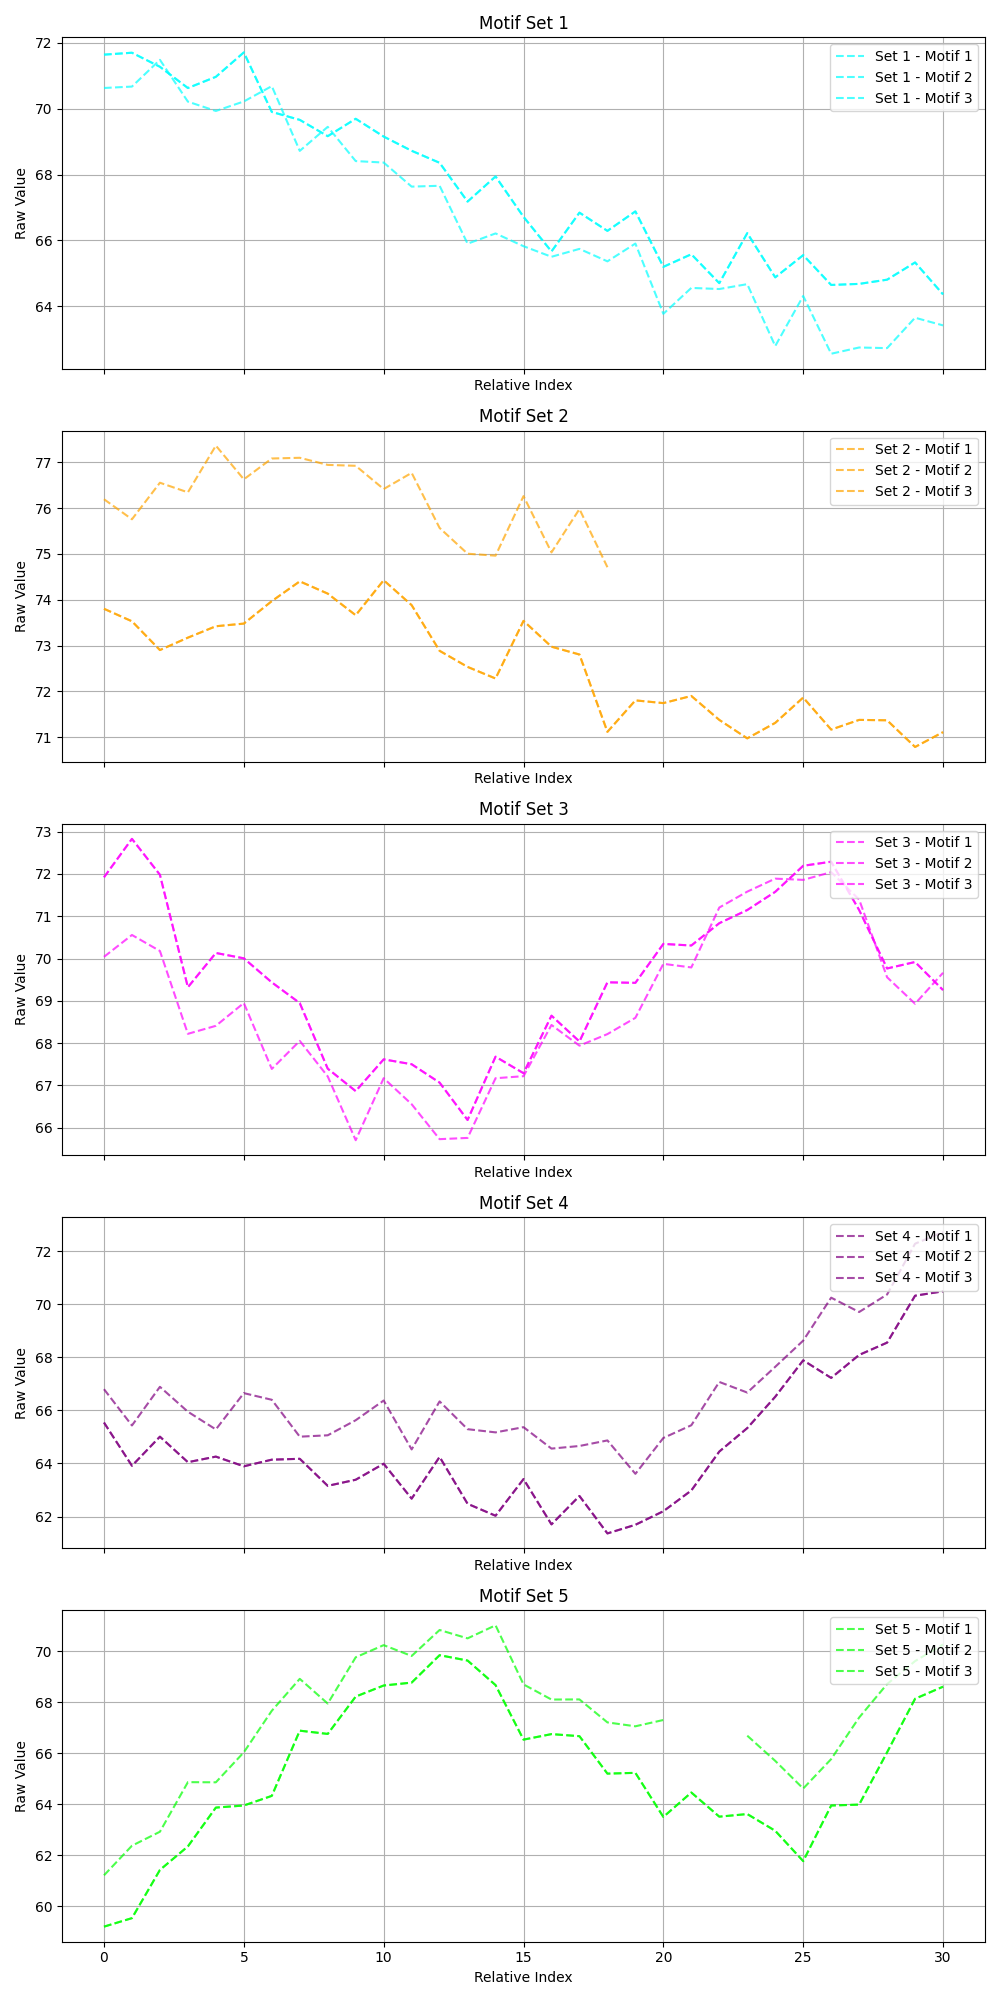

In [5]:
# %matplotlib widget

# 0. Ensure timestamp is correctly formatted
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df[df['timestamp'].notna()]
start, end = df['timestamp'].min(), df['timestamp'].max()
df = df[(df['timestamp'] >= start) & (df['timestamp'] <= end)]

# 1. Anomaly threshold (top 2% of distances)
threshold = df['matrix_profile'].quantile(0.98)
anomalies = df[df['matrix_profile'] > threshold]


plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['original_value'], label='Original value', color='green', alpha=0.6)

# Interpolated zones
for i in range(len(interpolated_mask)):
    if interpolated_mask.iloc[i]:
        ts = df['timestamp'].iloc[i]
        ts_next = df['timestamp'].iloc[i + 1] if i + 1 < len(df) else ts + pd.Timedelta(seconds=1)
        plt.axvspan(ts, ts_next, color='gray', alpha=0.1)

# Afficher les 5 premiers motifs de chaque set
colors = ['cyan', 'orange', 'magenta', 'purple', 'lime']
for set_id, motif_indices in enumerate(motif_sets):
    color = colors[set_id % len(colors)]
    for j, idx in enumerate(motif_indices[:10]):  # seulement les 5 premiers
        end_idx = min(idx + m, len(df) - 1)
        plt.axvspan(df['timestamp'].iloc[idx], df['timestamp'].iloc[end_idx], color=color, alpha=0.3,
                    label=f'Motif set {set_id+1}' if j == 0 else "")

# Anomalies (discords)
for ts in anomalies['timestamp']:
    plt.axvline(x=ts, color='red', linestyle='--', alpha=0.5)

plt.title("Original Signal with Multiple Motif Sets (First 5) and Anomalies")
plt.xlabel("Time")
plt.ylabel("Raw Value")
plt.legend(loc='upper right')
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()



# ---------- 2. Matrix Profile with annotations ----------
plt.figure(figsize=(14, 4))
plt.plot(df['timestamp'], df['matrix_profile'], label='Matrix Profile', color='orange')

# Anomaly markers
for ts, val in zip(anomalies['timestamp'], anomalies['matrix_profile']):
    plt.annotate('⬆', xy=(ts, val), color='red', fontsize=12, ha='center', va='bottom')

# Motif start + all neighbors
plt.scatter([df['timestamp'].iloc[motif_start]],
            [df['matrix_profile'].iloc[motif_start]],
            color='cyan', edgecolor='black', s=100, label='Motif Start')

for idx in motif_neighbors_idx:
    plt.scatter(df['timestamp'].iloc[idx], df['matrix_profile'].iloc[idx],
                color='cyan', edgecolor='black', s=60, alpha=0.6)


plt.title("Matrix Profile with Annotations")
plt.xlabel("Time")
plt.ylabel("Distance")
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# ---------- 3. ASWN-normalized signal ----------
plt.figure(figsize=(14, 4))
plt.plot(df['timestamp'], df['value'], label='ASWN Normalized', color='blue')
plt.title("ASWN Normalized Signal")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# 4. Motif Shapes — One Subplot per Motif Set (max 5 motifs par set)
fig, axs = plt.subplots(len(motif_sets), 1, figsize=(10, 4 * len(motif_sets)), sharex=True)

if len(motif_sets) == 1:
    axs = [axs]  # ensure iterable

for set_id, (motif_indices, ax) in enumerate(zip(motif_sets, axs)):
    color = colors[set_id % len(colors)]
    for i, idx in enumerate(motif_indices[:5]):  # max 5 motifs
        if idx + m <= len(df):
            motif_values = df['original_value'].iloc[idx : idx + m].reset_index(drop=True)
            label = f'Set {set_id+1} - Motif {i+1}'
            ax.plot(motif_values, linestyle='--', linewidth=1.5, color=color, alpha=0.7, label=label)
    ax.set_title(f"Motif Set {set_id+1}")
    ax.set_xlabel("Relative Index")
    ax.set_ylabel("Raw Value")
    ax.grid(True)
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

##  Summary: Matrix Profile Analysis with Interpolated and Normalized Time Series

In this section, we applied **motif and anomaly detection** using the **Matrix Profile** (`stumpy.aamp`) on a time series that was **pre-processed and locally normalized**.

### Key Steps:
1. **Preprocessing**: The original time series was linearly interpolated to fill missing data points.
2. **Local Normalization**: The signal was normalized using ASWN (Adaptive Sliding Window Normalization) to ensure local scale invariance.
3. **Automatic Window Inference**: The matrix profile window size `m` was automatically inferred based on the median sampling interval and a target motif duration (e.g., 10 minutes).
4. **Exclusion of Interpolated Regions**: To avoid falsely detecting motifs in artificially smoothed regions, areas without an original value (`original_value`) were **masked out** from the analysis.

### What the Results Show:
- The **original** and **ASWN-normalized** signals are shown in separate plots for clarity.
- The **matrix profile** (minimum distance to nearest subsequence) highlights:
  - **Spikes** → potential **anomalies** (rare or abnormal patterns).[e.g. Black Friday, Christmas]
  - **Troughs** → **repeated motifs**, typical segments in the data.
- **Interpolated flat zones** no longer produce false motifs, resulting in a more trustworthy analysis.

>  This approach enables robust motif and anomaly detection even on irregular or gappy signals, while preventing interpolation bias.
